In [13]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import csv

class Struct:
    pass

## Define classe que tem as funções do VNS (MyVNS)

In [14]:
class MyVNS:
    # o objetivo do shake é escolher uma solução aleatoria da k-esima estrutura de vizinhança
    def shake(self, x, k, probdata):
        y = copy.deepcopy(x)

        ridx1 = np.random.randint(0, probdata.n)
        ridx2 = np.random.randint(0, probdata.n)

        blockSize=50
        startIndex = np.random.randint(0, probdata.n - blockSize)
        blockIndices = range(startIndex, startIndex + blockSize)
        
        if k == 1:             # troca o plano por um diferente movimento 1-swap
            y.solution[ridx1] = np.random.choice([j for j in [0, 1, 2] if j != x.solution[ridx1]])
        elif k == 2:           # permutaçao de dois planos de manutenção em dois equipamentos diferentes
            y.solution[ridx1], y.solution[ridx2] = x.solution[ridx2], x.solution[ridx1]
        elif k == 3:           # Mudança de um bloco de equipamentos para outro plano (sair de mínimo local)
            # Pega o plano mais comum no bloco e muda para outro
            currentPlans = [x.solution[i] for i in blockIndices]
            currentPlan = max(set(currentPlans), key=currentPlans.count,)
            newPlan = np.random.choice([j for j in [0, 1, 2] if j != currentPlan])
            
            for i in blockIndices:
                y.solution[i] = newPlan

        return y

    # toma a decisao de mudar de vizinhança, comparando a solução imcubente x com a solução do shake y
    def neighborhoodChange(self, x, y, k):
        if y.fitness < x.fitness:
            x = copy.deepcopy(y)
            k = 1
        else:
            k += 1
            
        return x, k
        
    
    # retorna a primeira melhor solução que achar na estrutura de vizinhança local à solução x
    def firstImprovement(self, x, probdata, fobj, k):
        neighborhood_size = 100

        for j in range(neighborhood_size):
            current_solution = self.shake(x, k, probdata)
            
            if fobj(current_solution, probdata).fitness < fobj(x, probdata).fitness:
                return current_solution

        # se nao achou ninguem melhor, retorna a solução original mesmo mesmo
        return x    
    
    # retorna a melhor solução que achar na estrutura de vizinhança local à solução x
    def bestImprovement(self, x, probdata, fobj, k):
        neighborhood_size = 10
        best_solution = copy.deepcopy(x)

        for j in range(neighborhood_size):
            current_solution = self.shake(x, k, probdata)
            
            if fobj(current_solution, probdata).fitness < fobj(best_solution, probdata).fitness:
                best_solution = current_solution

        return best_solution   

## Define classe que tem a definição do problema (MyProblem)

In [15]:
class MyProblem:
    '''  
    Modelamos a solução x como a sequência de manutenções atribuídas em um vetor. exemplo
    
        eq1 eq2 ... eq500
    x = [2   0  ...   1]

        nesse exemplo, o equipamento eq1 executa a manutenção que tem custo 2, o equipamento eq2 manutenção que tem custo 0, ...
    '''
            
    def fobj1(self, x, probdata):
        # x.solution é um vetor com os custos de manutenção da i-esima maquina (0, 1 ou 2)
        # é só somar o vetor que temos a solução
        fitness = np.sum(x.solution)
        
        x.fitness = fitness

        return x
    
    def fobj2(self, x, probdata):
        # x.solution é um vetor com os custos de manutenção da i-esima maquina, também é o indice j de dipij
        # é só somar o os valores de dipij variando o valor de j
        fitness=0
        for i in range(0,probdata.n):
            j=x.solution[i]
            fitness = fitness + probdata.dipij[i,j]
        
        x.fitness = fitness

        return x
    
    def fobj_epsilon_penalidade(self, x, probdata):
        # x.solution é um vetor com os custos de manutenção da i-esima maquina, também é o indice j de dipij
        # é só somar o os valores de dipij variando o valor de j
        fitness=0
        for i in range(0,probdata.n):
            j=x.solution[i]
            # fitness = fitness + probdata.dipij[i,j] # f1
            fitness = fitness + np.sum(x.solution) # f2

        # soma o termo de penalidade (slide 9 02-ot-restrita)
        u = 100
        epsilon = 1600
        gx = self.fobj2(x, probdata).fitness - epsilon # f2 <= epsilon ===> f2 - epsilon <= 0

        fitness = fitness + u * (max(0, gx))**2
        
        x.fitness = fitness

        return x


    def sol_inicial(self, probdata, apply_constructive_heuristic):
        if apply_constructive_heuristic == False:        
            # Constrói solução inicial aleatoriamente
            x = Struct()
            x.solution = np.random.randint(0, 2 + 1, size=(probdata.n))
        
        else:
            # Constrói solução inicial usando uma heurística construtiva
            x = Struct()
            x.solution = np.random.randint(0, 2 + 1, size=(probdata.n))
            for i in range(probdata.n):        
                var = np.var(probdata.dipij[i,:]) 
                if var>0.5: #limiar da variância
                    x.solution[i]=2
                else:
                    x.solution[i]=0
            #print(x.solution)
        return x
    
    def probF(self,eta,beta,t):
        return (1-np.exp(-(t/eta)**(beta)))
    
    def probdef(self):
        n = 500 # número de equipamentos

        # extrai os dados do CSV e salva na matriz
        equip_db = np.zeros(shape=(n, 4))

        with open('arquivos_tc/EquipDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                equip_db[idx] = np.array(data_array)

        # agora le o arquivo mpdb
        mpdb = np.zeros(shape=(3, 3))
    	
        # custos do problema sao a ultima coluna do mpdb
        c = np.zeros(3)

        with open('arquivos_tc/MPDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                mpdb[idx] = np.array(data_array)
                c[idx] = data_array[len(data_array) - 1]

        # agora le o arquivo cluster
        cluster = np.zeros(shape=(4, 3))
    	
        with open('arquivos_tc/ClusterDB.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')

            for idx, row in enumerate(spamreader):
                row_array = ', '.join(row).split(',')
                data_array = []
                
                for item in row_array:
                    data_array.append(float(item))

                cluster[idx] = np.array(data_array)
        
        # geração da matriz dipij, cada linha é um equipamento i e cada coluna o dipij do plano de manutenção j
        dipij = np.zeros(shape=(n, 3))

        for i in range(0,n):
            clusterid=int(equip_db[i,2]-1)
            eta=cluster[clusterid,1]
            beta=cluster[clusterid,2]
            t0=equip_db[i,1]
            di=equip_db[i,3]
            
            for j in range(0,3):
                k=mpdb[j,1]
                Ft0=self.probF(eta,beta,t0)
                Ft0kt=self.probF(eta,beta,(t0+k*5))
                dipij[i,j]= di*(Ft0kt-Ft0)/(1-Ft0)
                # print(f"i={i}  j={j}  k={k}  eta={eta}  beta={beta}  t0={t0}  Ft0={Ft0}  Ft0kt={Ft0kt}  pij={(Ft0kt-Ft0)/(1-Ft0)}")
        
        probdata = Struct()
        probdata.equip_db = equip_db
        probdata.mpdb = mpdb
        probdata.c = c
        probdata.n = n
        probdata.dipij =dipij
            
        return probdata

# Loop principal começa aqui

Rodando execução 1...


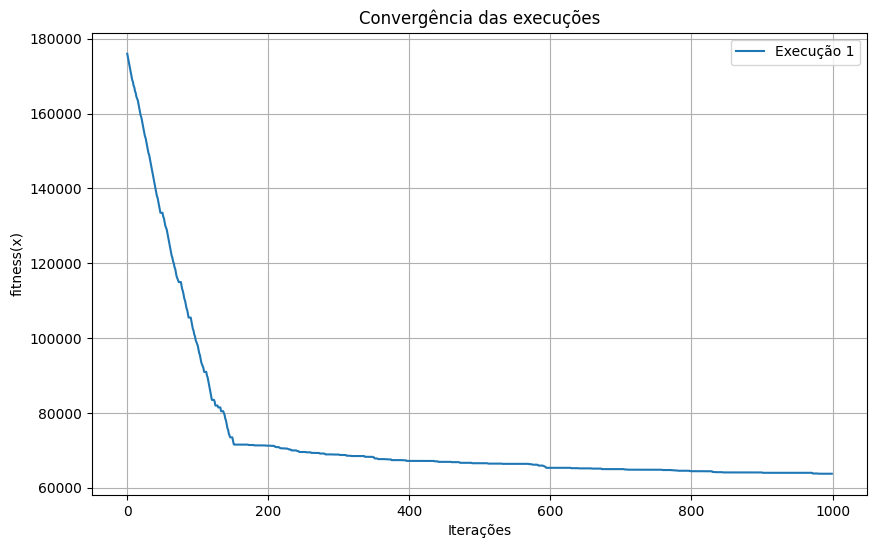


--- RESULTADOS FINAIS ---
Melhor solução: [0 0 2 0 0 0 0 0 2 0 0 0 0 2 0 2 0 0 0 0 1 2 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 1 1 0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 0 0 0 0 0 0 1 0 0
 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 2 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0
 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 2 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 0 0
 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0
 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 2 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 1 0 0 0 0
 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 

In [16]:
import matplotlib.pyplot as plt
import numpy as np

num_execucoes = 1
max_num_sol_avaliadas = 1000
kmax = 3

convergencias = []
melhores_fitness = []

for execucao in range(num_execucoes):
    print(f'Rodando execução {execucao + 1}...')

    # Cria instâncias dos objetos
    myProblem = MyProblem()
    myVNS = MyVNS()

    # Gera os dados do problema
    probdata = myProblem.probdef()

    # Gera uma solução inicial
    x = myProblem.sol_inicial(probdata, apply_constructive_heuristic=True)

    # Escolhe a função objetivo
    func_obj = myProblem.fobj_epsilon_penalidade  # Troque para fobj1 se quiser

    x = func_obj(x, probdata)
    num_sol_avaliadas = 1

    historico = Struct()
    historico.sol = []
    historico.fit = []
    historico.sol.append(x.solution)
    historico.fit.append(x.fitness)

    # loop principal (BVNS)
    while num_sol_avaliadas < max_num_sol_avaliadas:
        k = 1
        while k <= kmax:
            # Gera uma solução candidata na k-ésima vizinhança de x 
            y = myVNS.shake(x, k, probdata)

            # faz uma busca local a partir da solução candidata do shake
            y_local = myVNS.bestImprovement(x, probdata, func_obj, k)
            num_sol_avaliadas += 1

            # Atualiza solução corrente e estrutura de vizinhança (se necessário)
            x, k = myVNS.neighborhoodChange(x, y_local, k)

            # dados para plot
            historico.sol.append(x.solution)
            historico.fit.append(x.fitness)

    convergencias.append(historico.fit)
    melhores_fitness.append(x.solution)

    # print('\n--- SOLUÇÃO ENCONTRADA ---\n')
    # print('Manutenções atribuídas aos equipamentos:\n')
    # print('x = {}\n'.format(x.solution))
    # print('fitness(x) = {:.1f}\n'.format(x.fitness))

# --- PLOTAGEM DAS CURVAS DE CONVERGÊNCIA ---
plt.figure(figsize=(10,6))
for i in range(num_execucoes):
    plt.plot(convergencias[i], label=f'Execução {i+1}')
plt.title('Convergência das execuções')
plt.xlabel('Iterações')
plt.ylabel('fitness(x)')
plt.legend()
plt.grid(True)
plt.show()

# --- ESTATÍSTICAS FINAIS ---
media_fitness = np.mean(melhores_fitness)
desvio_fitness = np.std(melhores_fitness)

print(f'\n--- RESULTADOS FINAIS ---')
print(f'Melhor solução: {x.solution} ')
print(f'Melhores fitness encontrados: {melhores_fitness}')
print(f'Média: {media_fitness:.4f}')
print(f'Desvio padrão: {desvio_fitness:.4f}')
